# Teste 1 - Python

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente, há uma série de caracteres em primeira vista aleatórios que é atualizada... como puxar o arquivo csv automaticamente?
        O site não disponibiliza dados de SRAG, tabela repetida do COVID e desatualizada.
        Nova tabela com dados do Brasil (população)

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado
        
        Mostrar dados de SRAG e comparar com o aumento dos números confirmados de COVID
        Dados em semana epidemiológica

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        Estimar curvas com ajuda dos dados de SRAG inconclusivos (qual a porcentagem de testes incompletos espera-se que serão confirmados)
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2
  

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
url_S = "https://gitlab.procc.fiocruz.br/mave/repo/raw/master/Dados/InfoGripe/serie_temporal_com_estimativas_recentes.csv"
url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/4805484542de92e6b77e9321dfec2306_Download_COVID19_20200424.csv"

In [2]:
brasil = pd.read_csv(url_B, sep = ';')
df = pd.read_csv(url_C, sep = ";")
# df_SRAG = pd.read_csv(url_S, sep = ";")

In [3]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)


In [4]:
brasil

,UF,Unidade da Federação,Tipo,Regiao,População
0,RO,Rondônia,Estado,Norte,1857992
1,AC,Acre,Estado,Norte,866811
2,AM,Amazonas,Estado,Norte,4240210
3,RR,Roraima,Estado,Norte,546891
4,PA,Pará,Estado,Norte,8628901
5,AP,Amapá,Estado,Norte,842914
6,TO,Tocantins,Estado,Norte,1599316
7,MA,Maranhão,Estado,Nordeste,7121156
8,PI,Piauí,Estado,Nordeste,3233891
9,CE,Ceará,Estado,Nordeste,9178363


In [5]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

# df_S1 = df_SRAG.fillna(0)
# df_S1 = df_S1.loc[:, ['Unidade da Federação', 'Tipo', 'dado', 'Ano epidemiológico', 'Semana epidemiológica', 'Total reportado até a última atualização', 'casos estimados', 'População']]
# df_S1.drop(df_S1[df_S1["Ano epidemiológico"] != 2020].index, inplace=True)

#df_Brasil = df_S1.loc[:, ['Unidade da Federação', 'Tipo', 'População']]
#df_Brasil = df_Brasil.drop_duplicates("Unidade da Federação")

#df_Brasil.reset_index(inplace = True, drop = True)
# df_S1.reset_index(inplace = True, drop = True)

In [6]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)

# df_S1.replace({',' : '.'}) #, regex=True)
# df_S1

In [7]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    np.random.seed(19)
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

In [8]:
# total cases
x = list(df1.index)
y = list(df1.iloc[:, 0])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
#exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], 
                                                          exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]
exponential_errors

[11555732.472505411, 0.0017189766616913231, 1959548.5906459298]

In [9]:
# new cases
y = list(df1.iloc[:, 1])

new_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_exponential_fit[0][0],
                                                              new_exponential_fit[0][1], 
                                                              new_exponential_fit[0][2]) - int(new_exponential_fit[0][2]), new_exponential_fit[0][1]))
new_exponential_errors = [np.sqrt(new_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_exponential_errors

[1076517583.2890415, 0.0038257750027193642, 70649429.01756746]

In [10]:
# total deaths
y = list(df1.iloc[:, 2])

death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
death_exponential_sol = int(fsolve(lambda x : exponential_model(x, death_exponential_fit[0][0],
                                                                death_exponential_fit[0][1], 
                                                                death_exponential_fit[0][2]) - int(death_exponential_fit[0][2]), death_exponential_fit[0][1]))
death_exponential_errors = [np.sqrt(death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
death_exponential_errors

[335478614.5319366, 0.002131368272701741, 24996681.801247198]

In [11]:
# new deaths
y = list(df1.iloc[:, 3])

new_death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_death_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_death_exponential_fit[0][0], 
                                                                    new_death_exponential_fit[0][1], 
                                                                    new_death_exponential_fit[0][2]) - int(new_death_exponential_fit[0][2]), new_death_exponential_fit[0][1]))
new_death_exponential_errors = [np.sqrt(new_death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_death_exponential_errors

[573473849.9862406, 0.006510422483799444, 85854881.82808809]

## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [12]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

a0 = 1.7

b0 = df1.index.size + 31
b1 = b0 + 14

pBrasil = brasil.at[brasil['UF'].eq('BR').idxmax(),'População']
c0 = 0.4 * pBrasil
c1 = 0.04 * pBrasil
c2 = 0.02 * c0
c3 = 0.001 * c2

In [13]:
# total cases
y = list(df1.iloc[:, 0])

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
logistic_errors = [np.sqrt(logistic_fit[1][i][i]) for i in [0, 1, 2]]
logistic_errors

[0.14917764044028303, 0.5197766202131683, 2606.3260484568314]

In [14]:
# new cases
y = list(df1.iloc[:, 1])

new_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c1])
new_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_logistic_fit[0][0], new_logistic_fit[0][1], 
                                                        new_logistic_fit[0][2]) - int(new_logistic_fit[0][2]), new_logistic_fit[0][1]))
new_logistic_errors = [np.sqrt(new_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_logistic_errors

[1.2822525387324417, 3.431075969660704, 686.719596803228]

In [15]:
# total deaths
y = list(df1.iloc[:, 2])

death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c2])
death_logistic_sol = int(fsolve(lambda x : logistic_model(x, death_logistic_fit[0][0], death_logistic_fit[0][1], 
                                                          death_logistic_fit[0][2]) - int(death_logistic_fit[0][2]), death_logistic_fit[0][1]))
death_logistic_errors = [np.sqrt(death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
death_logistic_errors

[0.17615393679144223, 0.5851117323650259, 224.74319708407128]

In [16]:
# new deaths
y = list(df1.iloc[:, 3])
a0, b1, c3
new_death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c3])
new_death_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_death_logistic_fit[0][0], new_death_logistic_fit[0][1], 
                                                               new_death_logistic_fit[0][2]) - int(new_death_logistic_fit[0][2]), new_death_logistic_fit[0][1]))
new_death_logistic_errors = [np.sqrt(new_death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_death_logistic_errors

[8.356146824762862e+20, nan, nan]


# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

In [17]:
# df_S1.loc[df_S1.iloc[:, 0] == "Brasil", :].iloc[:, [2, 4, 5, 6]].reset_index(inplace = True, drop = True)
# df_S1
# #df_S2 = list(df_S1['dado'] == "sragcovid"].iloc[:, [1, 5]]) #'srag', 'sragflu', 'obitoflu', 'sragcovid', 'obitocovid', 'obito'
# #gapminder[~gapminder.continent.isin(continents) & 
# #           gapminder.year.isin(years)]

# df_S2 =  df_S1[df_S1['dado'].eq('sragcovid') & df_S1['Tipo'].eq('País')]
# df_S2 = df_S2.tail(16)
# df_S2

Expected final values: end of spread in 110 days with 80404.027 cases in Brazil


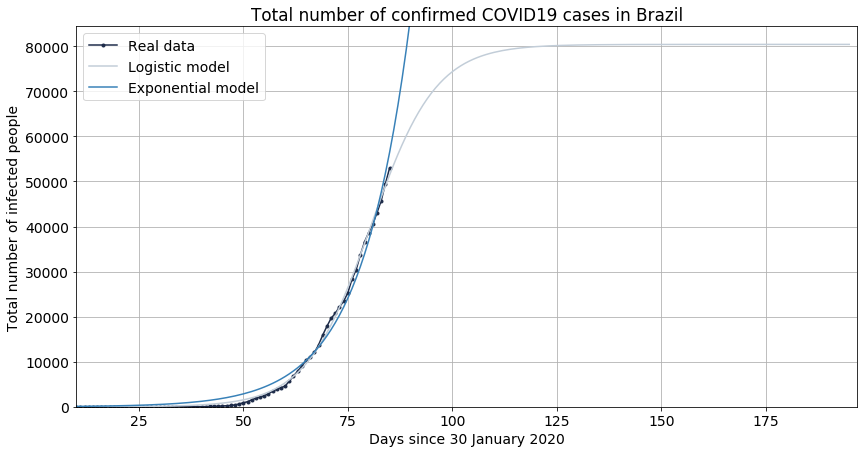

In [20]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))
y = list(df1.iloc[:, 0])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.xlim(10, max(pred_x) * 1.01)
plt.ylim(0, logistic_fit[0][2] * 1.05)
print("Expected final values: end of spread in " + str(max(pred_x) - max(x)) + " days, with " + str(round(logistic_fit[0][2], 3)) + " cases in Brazil")


In [ ]:
# plt.grid(True)
# plt.rc('font', size=14)
# plt.rcParams['figure.figsize'] = [14, 7]

# x_S = list(df_S2.iloc[:, 4])
# y_S = list(df_S2.iloc[:, 5])

# plt.plot(x_S, y_S, marker = '.', label = "Real data", color = "#a1a9b4")

# plt.title("Total number of confirmed COVID19 cases in Brazil")
# plt.legend()
# plt.xlabel("Days since 30 January 2020")
# plt.ylabel("Total number of infected people")
# plt.ylim(0, max(y_S) * 1.05)
# plt.show()

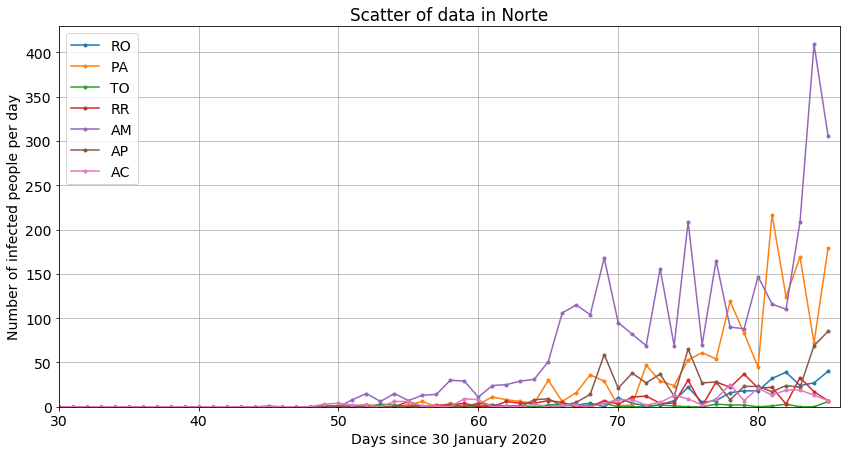

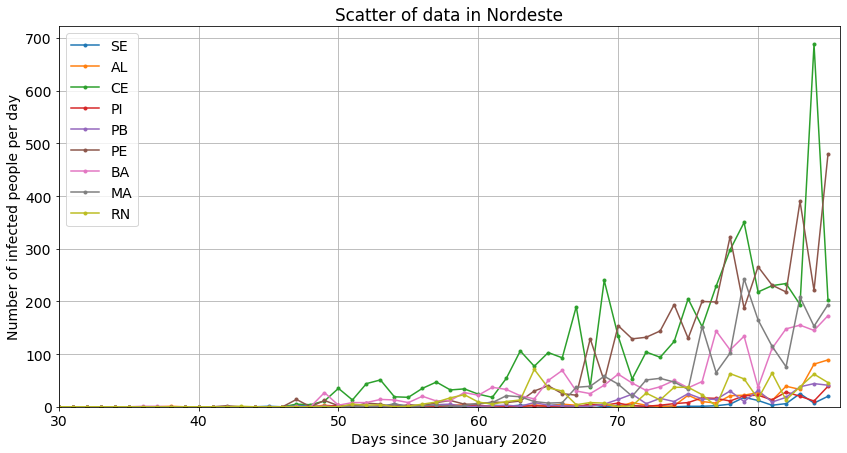

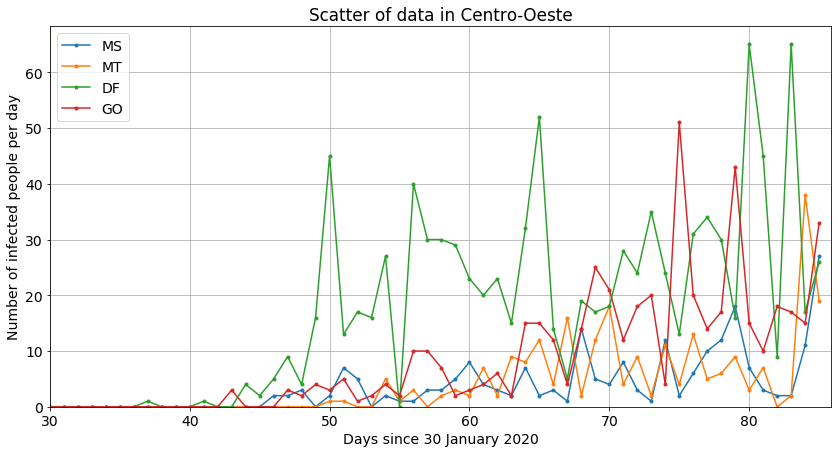

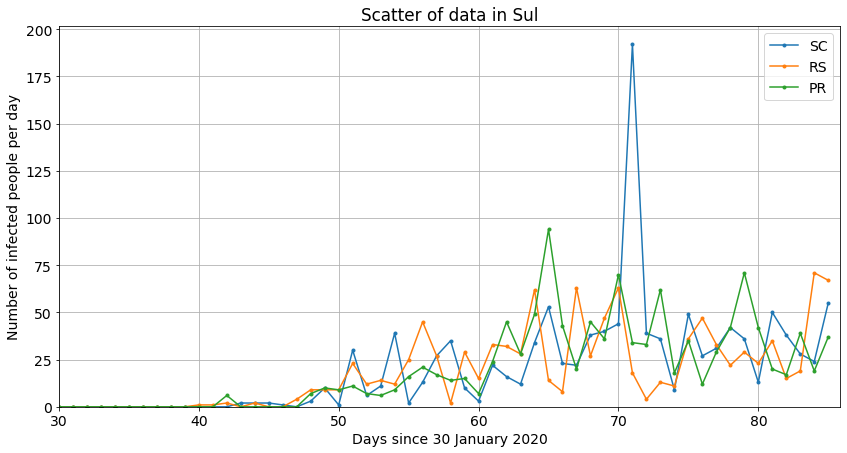

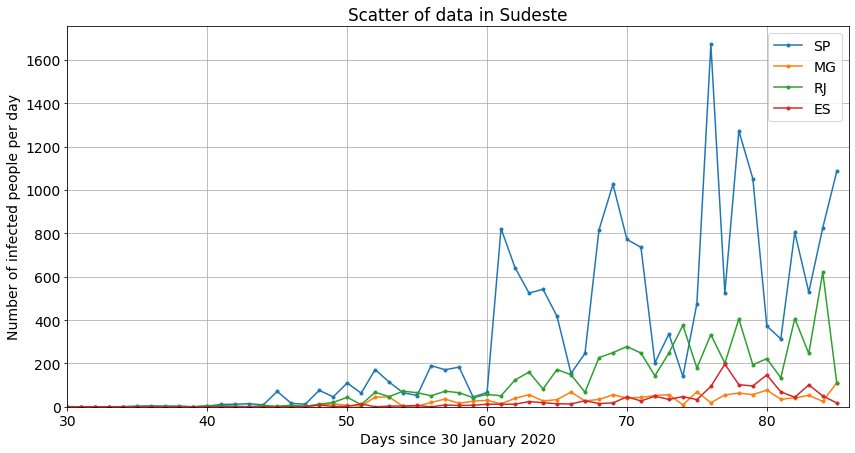

In [21]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

dfs = dfs.sort_values("data")
y = list(dfs.iloc[:, 3])

# Real data
# Brazilian areas separated

regioes = dfs["regiao"].unique()
estados = list(dfs["estado"].unique())

for r in regioes : 
    plt.grid(True)
    for e in estados :
        yx = max(dfs[dfs['regiao'] == r].iloc[:, 3])
        uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Regiao"]
        if uf == r :
            xs = list(dfs[dfs['estado'] == e].iloc[:, 1])
            ys = list(dfs[dfs['estado'] == e].iloc[:, 3])
            plt.plot(xs, ys, marker = '.', label = e)
    plt.title("Scatter of data in " + r)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Number of infected people per day")
    plt.xlim(30, max(xs) * 1.01)
    plt.ylim(0, yx * 1.05)
    plt.show()


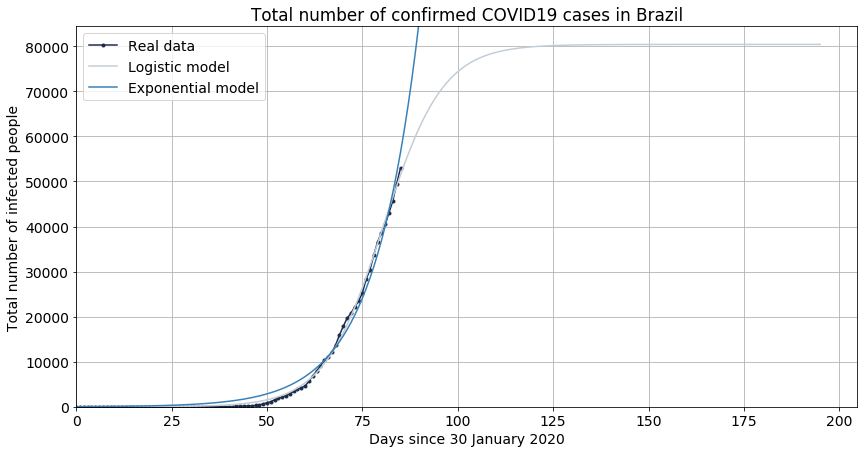

Expected final values: end of spread in 110 days, with 80404.027 cases in Brazil


In [22]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))
y = list(df1.iloc[:, 0])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.xlim(0, max(pred_x) * 1.05)
plt.ylim(0, logistic_fit[0][2] * 1.05)
plt.show()
print("Expected final values: end of spread in " + str(max(pred_x) - max(x)) + " days, with " + str(round(logistic_fit[0][2], 3)) + " cases in Brazil")

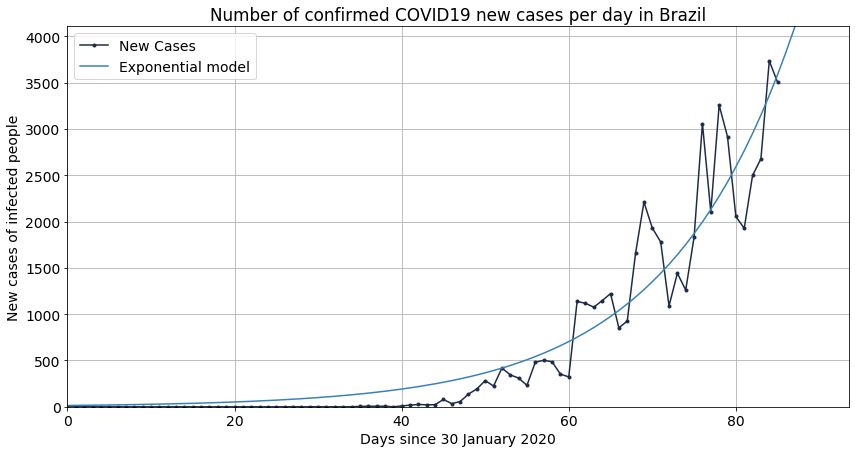

Next number of confirmed new cases is 3829.523


In [24]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), new_logistic_sol))
y = list(df1.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "New Cases", color="#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2])
                    for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of confirmed COVID19 new cases per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New cases of infected people")
plt.ylim(0, max(y) * 1.1)
plt.xlim(0, max(x) * 1.1)
plt.show()
print("Next number of confirmed new cases is "+ str(round(exponential_model(max(x) + 1, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2]), 3)))

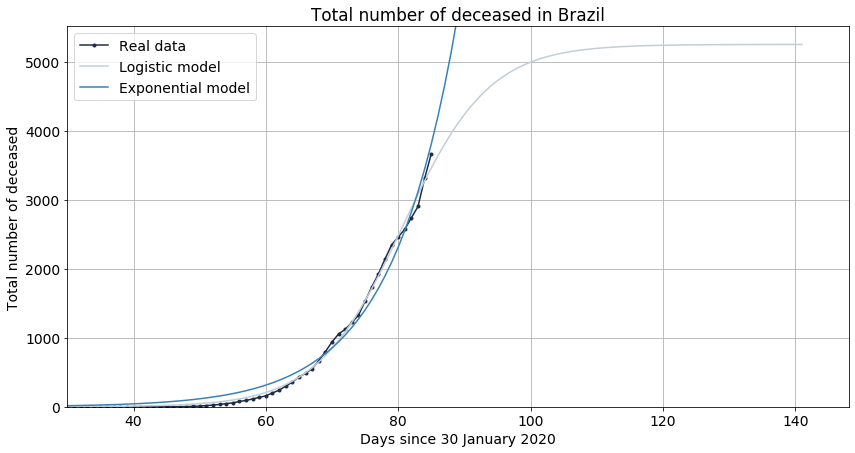

Expected final values: end of spread in 56 days, with 5254.374 cases in Brazil


In [26]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))

y = list(df1.iloc[:, 2])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, death_logistic_fit[0][0], death_logistic_fit[0][1], death_logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, death_exponential_fit[0][0], death_exponential_fit[0][1], death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of deceased in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of deceased")
plt.xlim(30, max(pred_x) * 1.05)
plt.ylim(0, death_logistic_fit[0][2] * 1.05)
plt.show()
print("Expected final values: end of spread in " + str(max(pred_x) - max(x)) + " days, with " + str(round(death_logistic_fit[0][2], 3)) + " cases in Brazil")

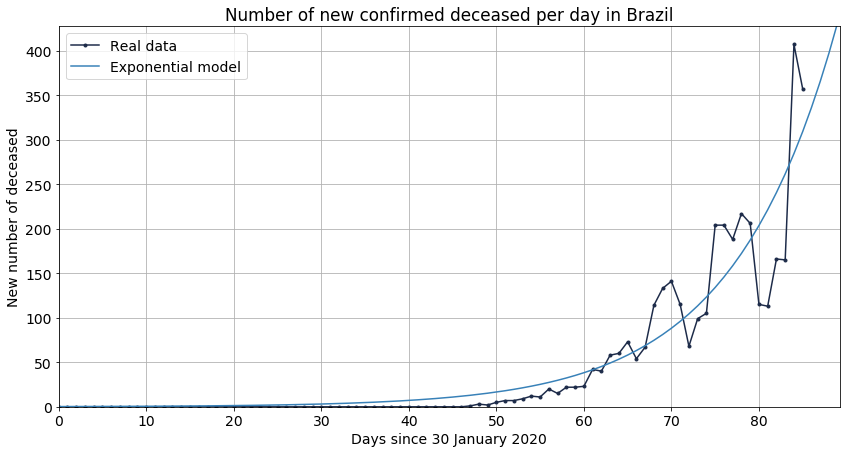

Next number of confirmed is 336.053


In [27]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 3])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of new confirmed deceased per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New number of deceased")
plt.xlim(0, max(x) * 1.05)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Next number of confirmed is "+ str(round(exponential_model(max(x) + 1, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2]), 3)))

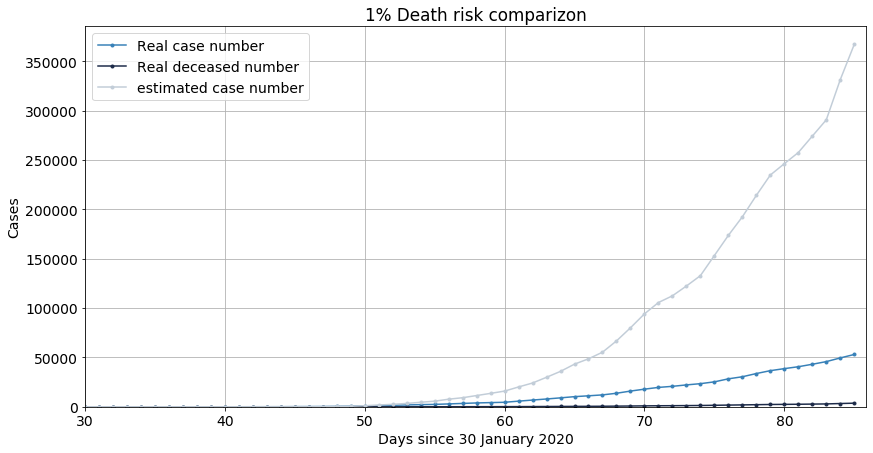

Expected actual value is: 367000 in day 85


(85, 367000)

In [29]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.01)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))
(max(x), max(y))

## Casos Totais por estado
    
    Casos confirmados x tempo
    
    Dados reais, estimativa exponencial e em estados com mais de 1000 casos estimativa logistica
    
    Os dados são subnotificados e possuem baixa confiabilidade

Next number of confirmed is 351.28 in RO


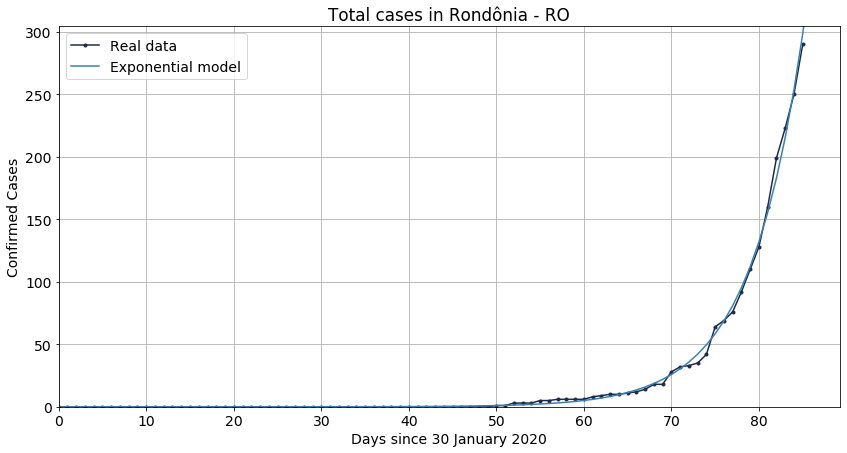

Next number of confirmed is 141.674 in SE


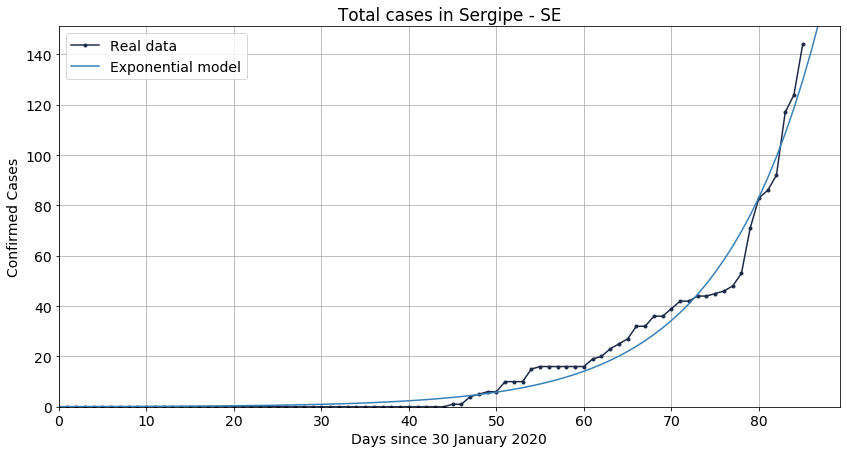

Next number of confirmed is 235.911 in MS


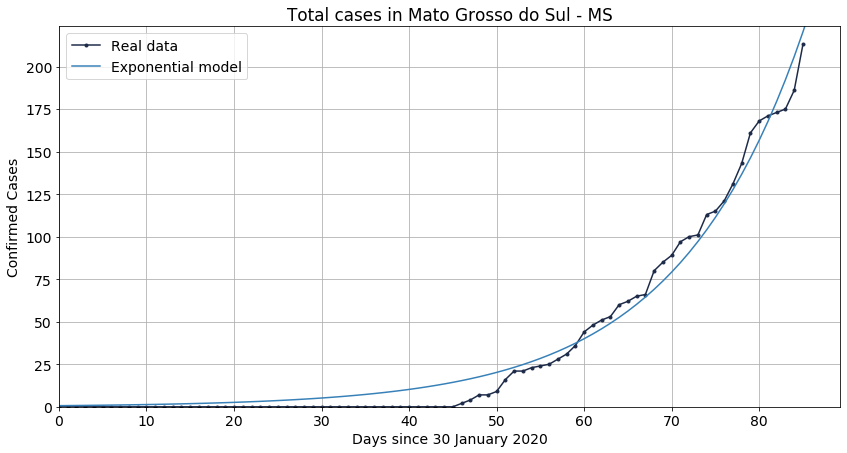

Expected final values: end of spread in 140 days with 4680.55 cases in PA
Next number of confirmed is 1748.547 in PA


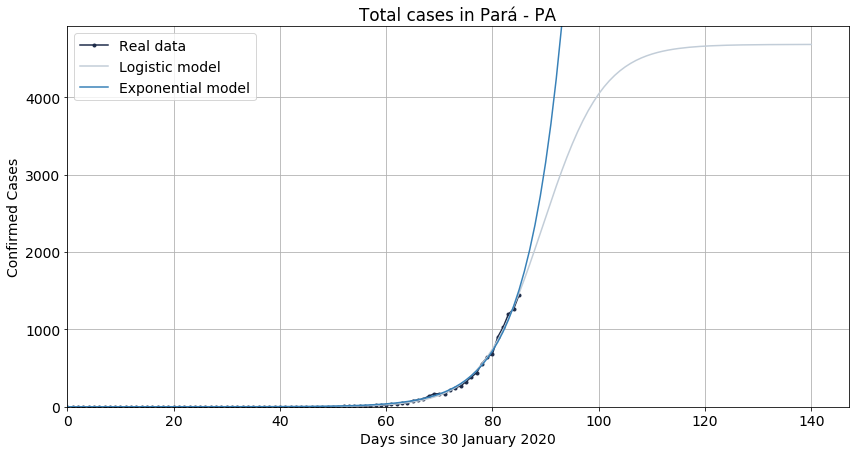

Next number of confirmed is 48.481 in TO


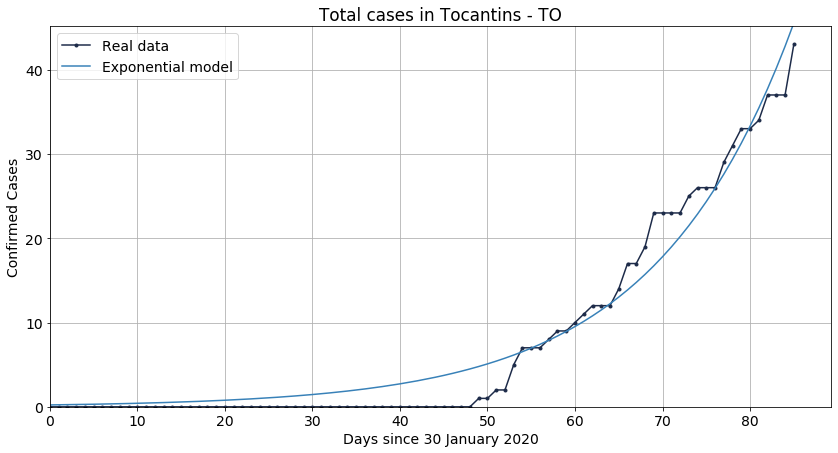

Expected final values: end of spread in 125 days with 1275.238 cases in SC
Next number of confirmed is 1454.222 in SC


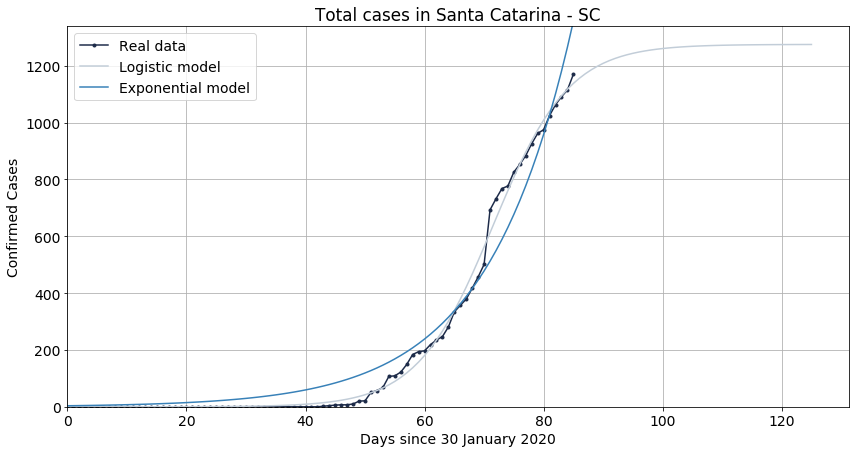

Next number of confirmed is 381.819 in RR


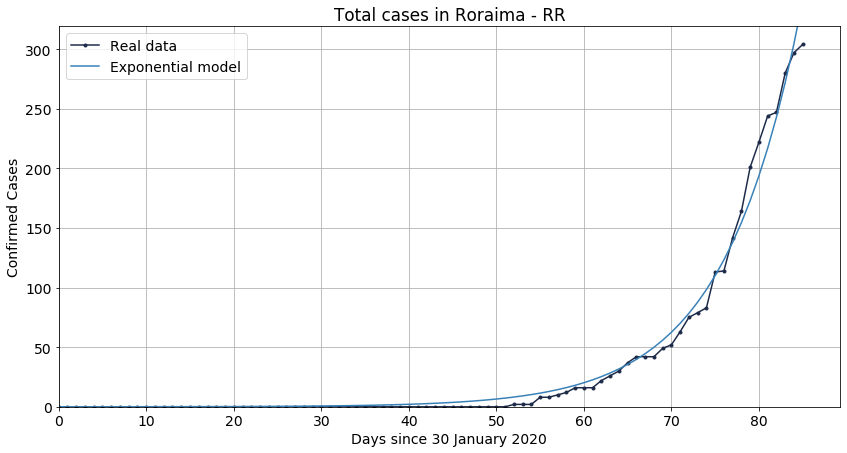

Next number of confirmed is 272.806 in MT


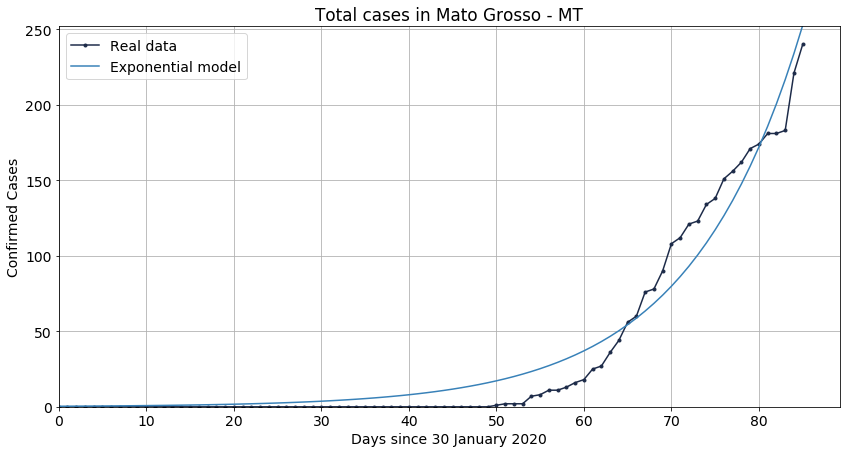

Next number of confirmed is 1173.836 in DF


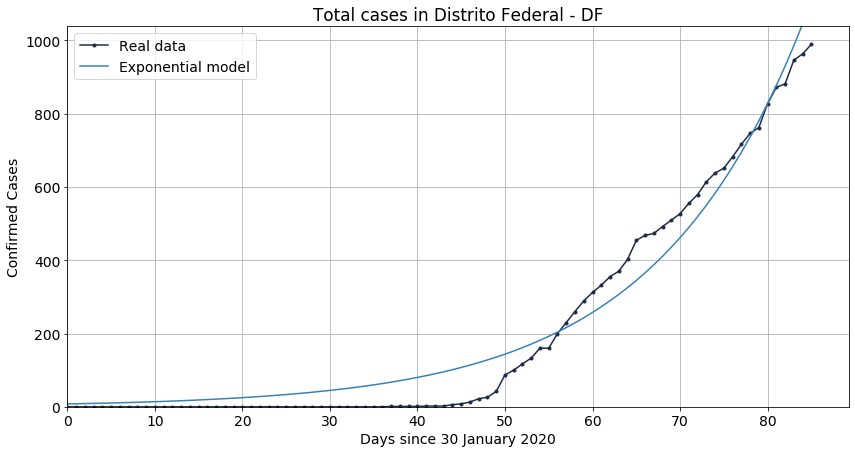

Expected final values: end of spread in 138 days with 4328.604 cases in AM
Next number of confirmed is 3579.2 in AM


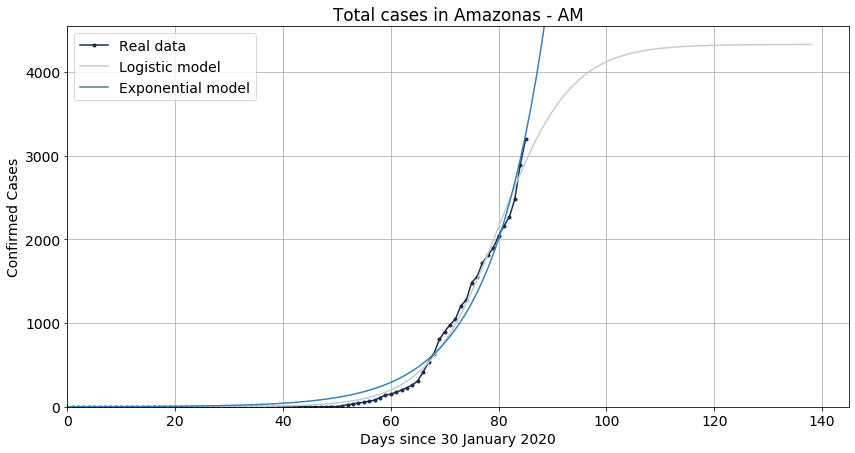

Next number of confirmed is 453.716 in AL


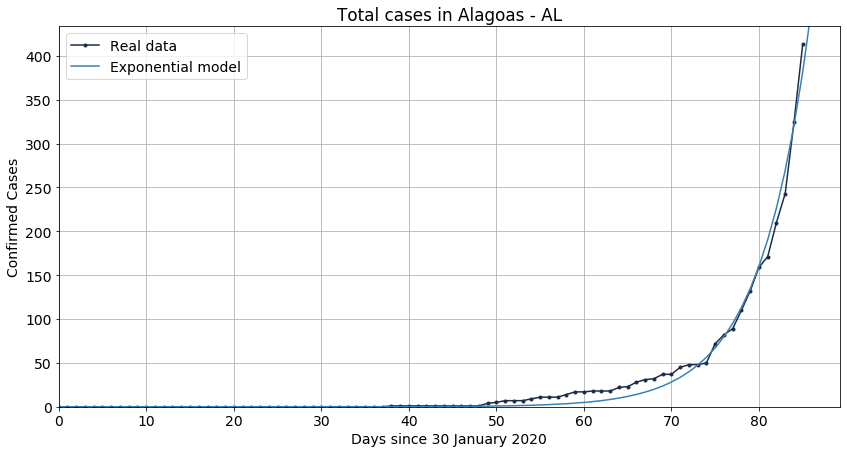

Expected final values: end of spread in 179 days with 11000.156 cases in CE
Next number of confirmed is 5484.154 in CE


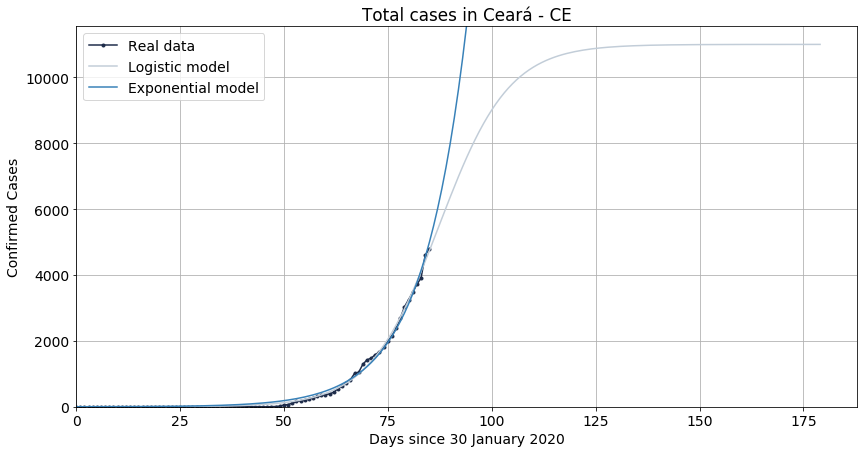

Expected final values: end of spread in 146 days with 21794.824 cases in SP
Next number of confirmed is 21334.446 in SP


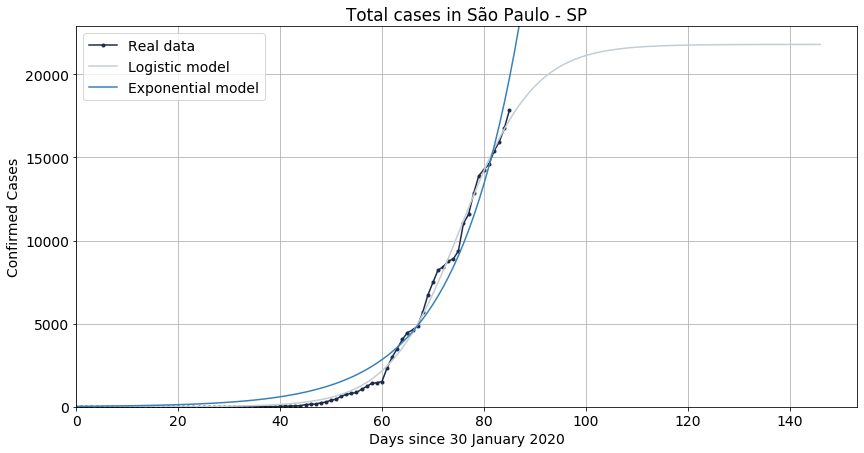

Next number of confirmed is 296.016 in PI


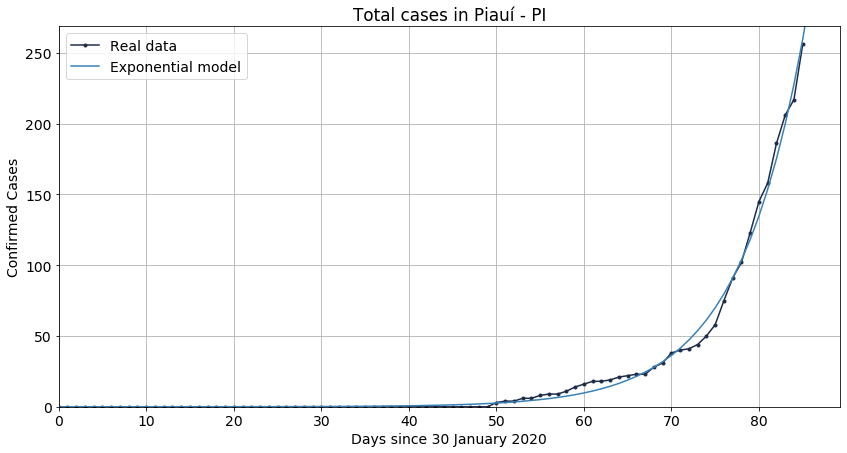

Expected final values: end of spread in 132 days with 1657.747 cases in MG
Next number of confirmed is 1669.833 in MG


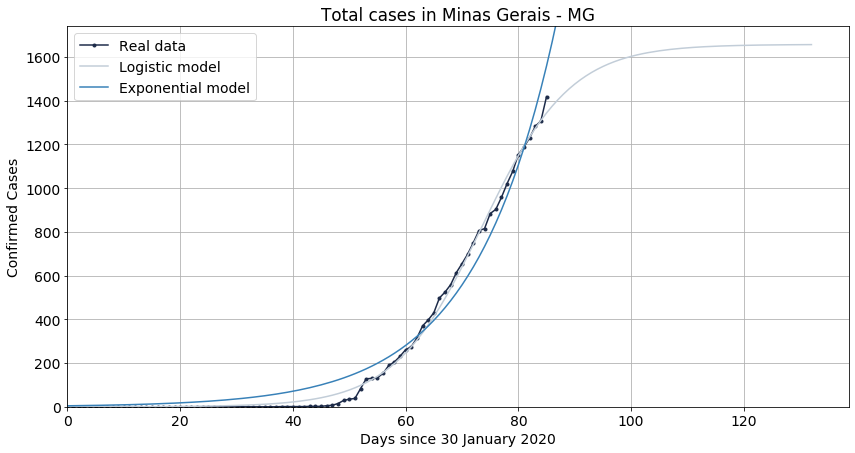

Next number of confirmed is 443.133 in PB


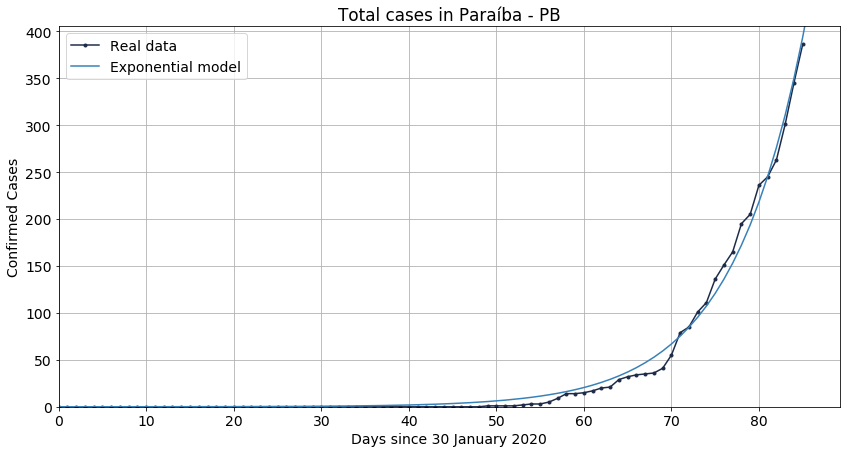

Expected final values: end of spread in 140 days with 5898.056 cases in PE
Next number of confirmed is 4775.28 in PE


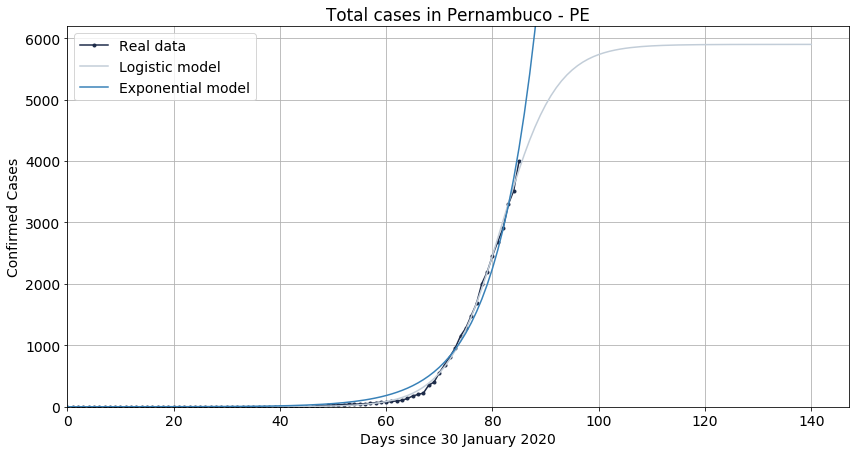

Expected final values: end of spread in 181 days with 7797.882 cases in BA
Next number of confirmed is 2169.698 in BA


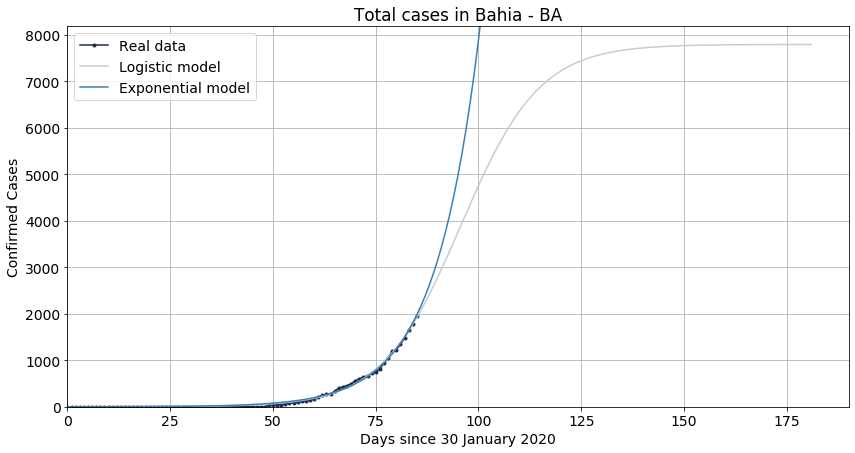

Expected final values: end of spread in 132 days with 1062.122 cases in RS
Next number of confirmed is 1247.171 in RS


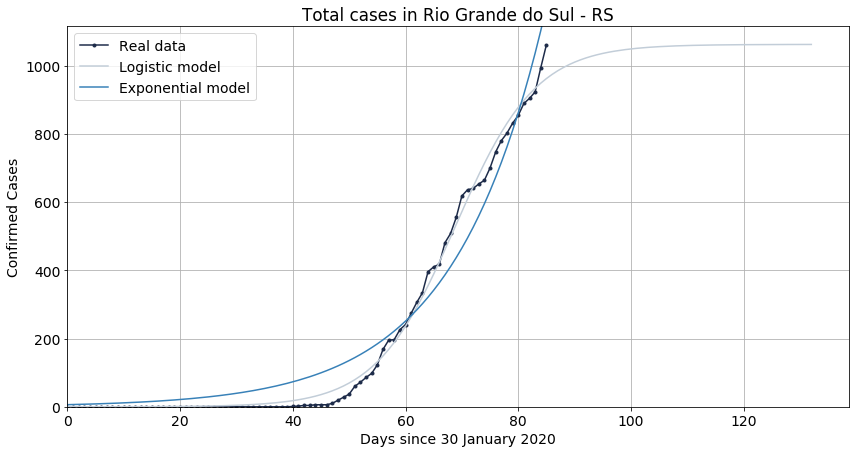

Next number of confirmed is 583.585 in GO


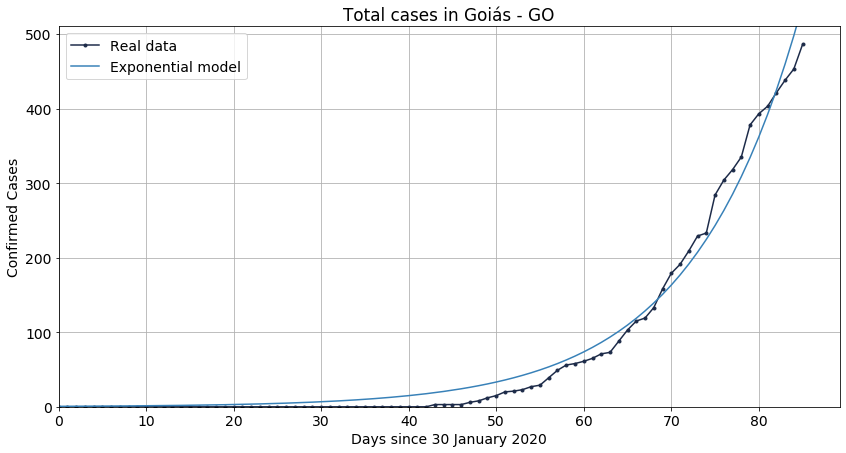

Next number of confirmed is 734.046 in AP


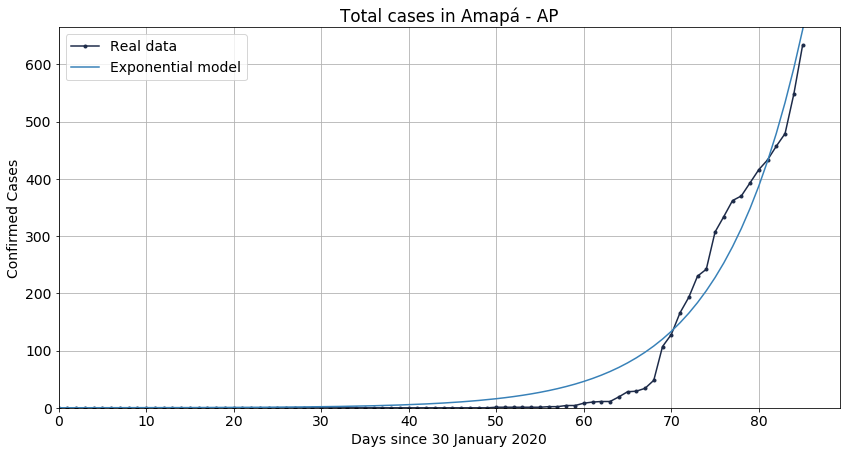

Expected final values: end of spread in 142 days with 8458.966 cases in RJ
Next number of confirmed is 7511.443 in RJ


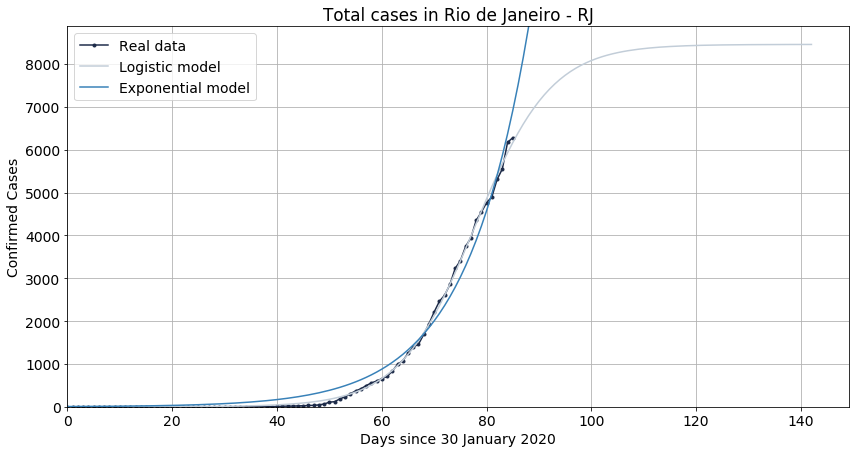

Expected final values: end of spread in 128 days with 3509.562 cases in MA
Next number of confirmed is 2371.448 in MA


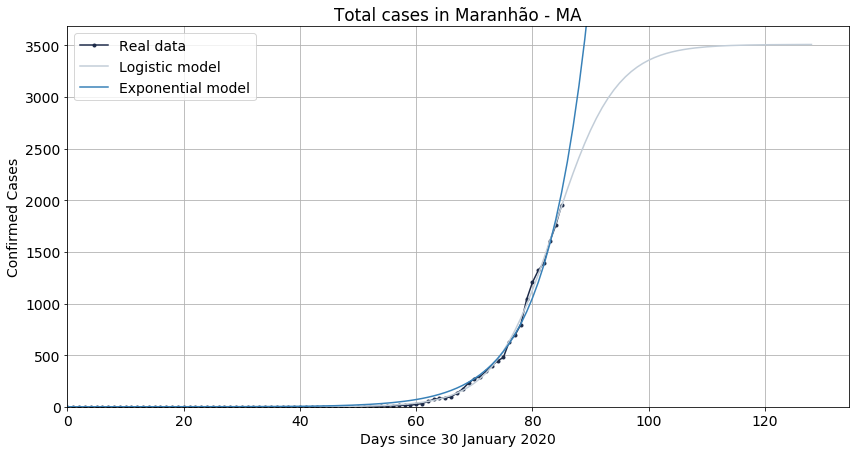

Next number of confirmed is 267.906 in AC


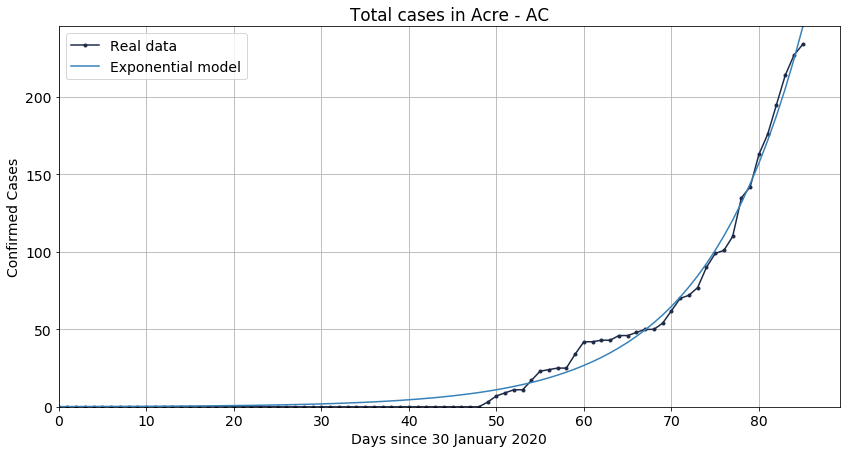

Next number of confirmed is 863.589 in RN


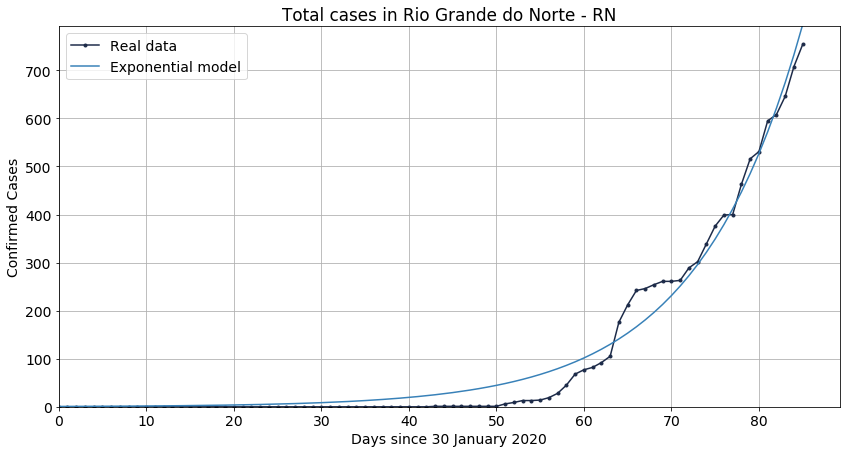

Expected final values: end of spread in 121 days with 2037.767 cases in ES
Next number of confirmed is 1783.848 in ES


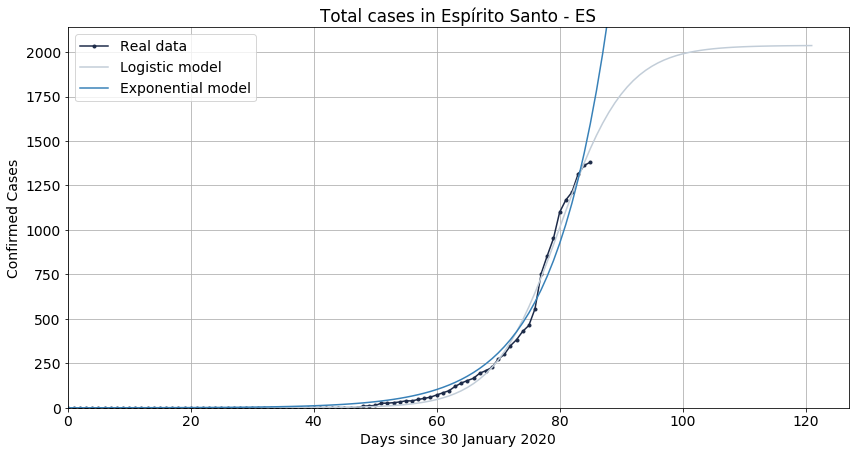

Expected final values: end of spread in 112 days with 1167.817 cases in PR
Next number of confirmed is 1409.833 in PR


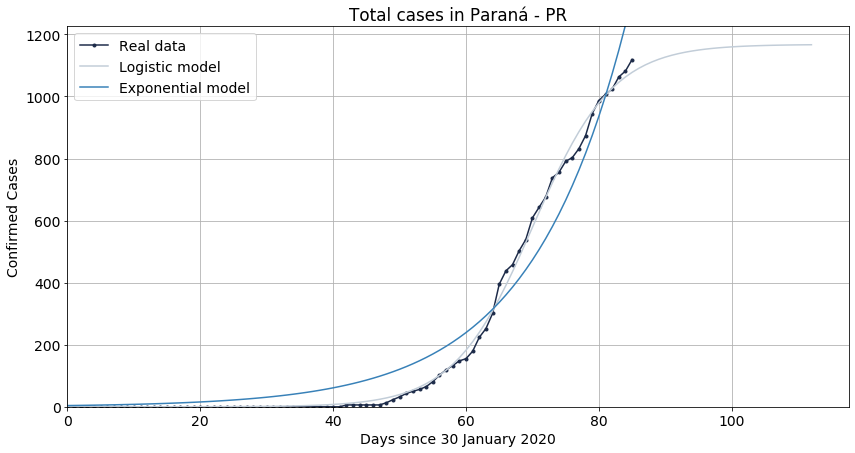

In [32]:
plt.grid(True)
plt.rcParams['figure.figsize'] = [14, 7]

estados = dfs["estado"].unique()

for e in estados :
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 2]]
    pop = brasil.at[brasil['UF'].eq(e).idxmax(),'População']
    uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Unidade da Federação"]
    x = list(df_e.iloc[:, 0])
    y = list(df_e.iloc[:, 1])

    plt.grid(True)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

    exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df_e.index.size))
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                                  exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

    if max(y) > 1000 :
        logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
        logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                            logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

        pred_x = list(range(max(x), logistic_sol))

        # Predicted logistic curve
        plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                              for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
        
        plt.xlim(0, max(pred_x) * 1.05)
        plt.ylim(0, logistic_fit[0][2] * 1.05)
        print("Expected final values: end of spread in " + str(max(pred_x)) + " days with " + str(round(logistic_fit[0][2], 3)) + " cases in " + e)
        
    else :
        plt.xlim(0, max(x) * 1.05)
        plt.ylim(0, max(y) * 1.05)

    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    print("Next number of confirmed is "+ str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)) + " in " + e)
    
    plt.title("Total cases in " + uf + ' - ' + e)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Confirmed Cases")
    plt.show()        

In [ ]:
#debugging

est = 'MG'

df_PE = df_UF.loc[df_UF.iloc[:,0] == est, :].iloc[:, [1, 2]]
pop = brasil.at[brasil['UF'].eq(est).idxmax(),'População']
y = list(df_PE.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in " + brasil.at[brasil['UF'].eq(est).idxmax(), "Unidade da Federação"])
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()